<a href="https://colab.research.google.com/github/AudePertron/AI_days_emotions/blob/main/Tuto_Emotions_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconnaissance des Emotions - 1/2

## - Exploration des données et création des Datasets, 

## - Entraînement du modèle d'identification des émotions

<hr>

- <a href='#1'>Prévisualisation des données</a>
- <a href='#2'>Création des datasets d'apprentissage et de test</a>
- <a href='#3'>Préparation des données</a>
- <a href='#4'>Entrainement du modèle de reconnaissance des émotions</a>
- <a href='#5'>Résultats</a> 

<hr>

In [1]:
#préparation des imports (bibliothèques et librairies nécéssaires à l'éxécution du code)
import os
import sys
import numpy as np
import cv2
import pickle

from glob import glob

from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from keras.layers import Conv2D, experimental, Dense, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.utils import to_categorical

### <a id='1'>Prévisualisation des données</a>

>Si vous souhaitez exécuter ce notebook sur Google Colab, l'exécution des cellules suivantes vous permettra de cloner directement le repository Git sur Colab, et d'y extraire le ficher .zip de la data.

>Vous pouvez bien sûr choisir d'exécuter les notebooks en local sur votre ordinateur, particulièrement si vous possédez un GPU. __Dans ce cas, il est inutile d'executer les 3 cellules suivantes.__

In [ ]:
!git clone https://github.com/AudePertron/AI_days_emotions.git

In [ ]:
!unzip /content/AI_days_emotions/data/emotions.zip -d /content/AI_days_emotions/data

In [ ]:
%cd AI_days_emotions/

Notre dossier Data contient l'ensemble des données, séparées en données d'entraînement et données de test, elles-mêmes divisées en sous-dossiers par émotions. Chaque sous-dossier d'émotions contient des images en noir et blanc de 48*48 pixel.

In [8]:
#nous accédons aux données depuis le dossier dans lequel elles sont stockées
tmp = os.listdir("./data/train") 

print("La liste 'tmp' contient les noms de chacun des dossiers. Les voici :")
print(" -", "\n - ".join(tmp))

#On prépare les labels (noms des émotions) en les récupérant à partir des noms de dossier.
#On prépare d'abord un dictionnaire qui contiendra les numéros et les noms des classes 
#en fonction des noms des dossiers.
LABELS ={} 
for clas, feeling in enumerate(tmp): # on itère sur la liste tmp pour récupérer ces labels.
    LABELS[clas]=feeling

NUM_CLASS = len(tmp) # le nombre de classes correspond au nombre de dossiers

print("\nIl y a donc", NUM_CLASS, "classes :")
print(LABELS)

La liste 'tmp' contient les noms de chacun des dossiers. Les voici :
 - angry
 - happy
 - sad
 - surprise

Il y a donc 4 classes :
{0: 'angry', 1: 'happy', 2: 'sad', 3: 'surprise'}


In [10]:
#nous indiquons l'emplacement des images, et créons une liste d'entraînement et une liste de test vide

trainset = []
for i in tmp: # on itère sur tmp pour parcourir chacun des 4 dossiers
    chemin = "./data/train/"+i
    img = glob("%s/*.jpg" %chemin) # la fonction glob permet de récupérer tous les fichiers d'un dossier
    img = [os.path.abspath(x) for x in img]
    trainset.append(img)

testset = []
for i in tmp:
    chemin = "./data/test/"+i
    img = glob("%s/*.jpg" %chemin)
    img = [os.path.abspath(x) for x in img]
    testset.append(img)

#Nous affichons le nombre d'images par catégorie :
print("Nombre d'images de chaque classe dans le train set :")
print([(LABELS[i], len(trainset[i])) for i in range(len(trainset))])
print("Et dans le test set :")
print([(LABELS[i], len(testset[i])) for i in range(len(testset))])

Nombre d'images de chaque classe dans le train set :
[('angry', 3995), ('happy', 7215), ('sad', 4830), ('surprise', 3171)]
Et dans le test set :
[('angry', 958), ('happy', 1774), ('sad', 1247), ('surprise', 831)]


### <a id='2'>Création des datasets d'apprentissage et de test</a>

Nous créons les données d'entraînement. 


Notre objectif, plus communément appelé "target" et abrégé en "y" est le nom de l'émotion associée à chaque image, qu'on appellera "label". Il s'agit d'associer chaque y au X correspondant. Donc par exemple si `X[0]` correspond à une image d'une personne heureuse, `y[0]` sera égal à la variable "happy" (les noms de variables sont ici représentés par des chiffres, comme vu ci-dessus)


In [11]:
# Nous créons la liste y_train (target sur les données d'entraînement)
paths=[]
y_train=[]

for i in range(len(trainset)):
    for j in range(len(trainset[i])):
        paths.append(trainset[i][j])
        y_train.append(i)

Les données que nous devons analyser, appelées "features" et abrègées en "X", sont les images. Chaque image est représenté par une matrice de taille 48x48 (hauteur * largeur de l'image en pixel), dont les chaque valeur peut varier entre 0 et 255 suivant la valeur du pixel en niveaux de gris (0 représentant le noir et 255 le blanc). Il y aurait trois matrices pour chacune des valeurs RGB (rouge, vert, bleu, les couleurs primaires pour la lumière) dans le cas d'images en couleurs.

Pour charger ces images sous forme de matrices d'entiers entre 0 et 255, nous utilisons le module `imread` de la bibliothèque `OpenCV` (`cv2`).

In [13]:
X_train=[]
for p in paths:
    X_train.append(cv2.imread(p, 0))

Préparation des données de test, de la même façon que les données d'entraînement. Ces données serviront à évaluer notre modèle, c'est à dire à vérifier que notre modèle fonctionne bien sur de nouvelles images, sur lesquelles il n'a pas été entraîné.

In [14]:
paths2=[]
y_test=[]

for i in range(len(testset)):
    for j in range(len(testset[i])):
        paths2.append(testset[i][j])
        y_test.append(i)

In [15]:
X_test=[]
for p in paths2:
    X_test.append(cv2.imread(p, 0))

### <a id='3'>Préparation des données</a>

###### Chargement des données

Nous allons maintenant visualiser une image du dataset pour vérifier que tout fonctionne correctement. Nous affichons de façon arbitraire l'image numéro 42, n'hésitez pas à modifier cette variable si vous souhaitez visualiser d'autres images du dataset.
Nous en profitons pour afficher la dimension de l'image, comme mentionné précédemment, elle fait 48*48 pixel. La longueur de X_train indique le nombre d'images contenu dans le dataset.

In [ ]:
plt.imshow(X_train[42], cmap="gray")
plt.axis("off")
print(f"Il y a {len(X_train)} images de {X_train[42].shape} pixels dans le dataset.\
 \nVoici par exemple l'image n°42 :")

###### Mélange des données

Nous allons maintenant mélanger les données (comme si l'on mélangeait des cartes avant une partie) car elles sont pour l'instant classées dans l'ordre des émotions.

In [ ]:
# pour l'entraînement
# on crée un vecteur de nombres de allant de 0 à 1921 triés aléatoirement 
index = np.random.permutation([i for i in range(len(y_train))]) 
# on classe X_train et y_train suivant cet ordre aléatoire.
X_train = np.asarray(X_train)[index] 
y_train = np.asarray(y_train)[index]
print(X_train.shape)
print(y_train.shape)

In [ ]:
# pour les tests
index2 = np.random.permutation([i for i in range(len(y_test))])

X_test = np.asarray(X_test)[index2]
y_test = np.asarray(y_test)[index2]
print(X_test.shape)
print(y_test.shape)

Visualisons maintenant quelques-une de ces images, par exemple les 15 premières, en affichant le label, afin de vérifier notre dataset avant de commencer l'entraînement.

In [ ]:
# visualisation
plt.figure(figsize=(15,9))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(np.uint8(X_train[i]), cmap='gray')
    plt.title(LABELS[y_train[i]])
    plt.axis('off')
plt.show()

###### Prétraitement en vue de l'entrainement avec un CNN Séquentiel 

Il s'agit de transformer les données dans le format attendu par l'algorithme. 

Il faut d'abord normaliser les données, c'est à dire transformer toutes les valeurs de pixels afin qu'elles soient comprises entre 0 et 1. Comme la valeur maximale d'un pixel est de 255, il suffit de diviser les valeurs par ce nombre. 

Puis nous donnons la "forme" attendue à notre matrice. Nous précisons de canaux de nos images : "1" pour une image en noir et blanc ("3", correspondant aux canaux rouge, vert,  bleu, pour une image en couleur).

In [31]:
# standardisation, redimensionnement des features
X_train = X_train.astype('float') / 255
X_test = X_test.astype('float') / 255
X_train = X_train.reshape(len(X_train),48,48,1)
X_test = X_test.reshape(len(X_test),48,48,1)

Nous encodons également nos valeurs-cibles (targets) y. Plutôt qu'avoir des valeurs entre 0 et 4 correspondant à un numéro arbitraire, nous le transformons en une liste de 0 et de 1, le 1 correspondant à l'émotion représentée.

Par exemple, dans le cas de la joie, qui était auparavant égale à 3, nous aurons :
- avant : `y=1`
- après : `Y=[0,1,0,0]`

ou pour la tristesse:
- avant : `y=3`
- après : `Y=[0,0,1,0]`
et ainsi de suite.

Cela permet d'éviter des biais car l'algorihtme pourrait accorder une plus grande importance à une émotion dont la valeur est plus élevée (considérer qu'une émotion avec pour valeur 4 est plus importante qu'une émotion avec une valeur 0).

In [32]:
# catégorisation des target
y_test.reshape(len(y_test),1)
y_train.reshape(len(y_train),1)
Y_train = to_categorical(y_train, num_classes=NUM_CLASS).astype(int)
Y_test = to_categorical(y_test, num_classes=NUM_CLASS).astype(int)

In [ ]:
# vérificationpour un élément au hasard du set d'entrainement
print(Y_train[42], y_train[42], LABELS[y_train[42]]) 

In [ ]:
# vérificationpour un élément au hasard du set de test
print(Y_test[42], y_test[42], LABELS[y_test[42]]) #test

### <a id='4'>Entrainement du modèle de reconnaissance des émotions</a>

###### Création du modèle séquentiel

Nous allons maintenant appliquer un réseau de neurones convolutif sur nos données. Le temps d'entraînement peut être long, aussi, __pour gagner du temps, nous vous proposons de télécharger notre modèle préentraîné par la suite__, mais à nouveau, si en vous avez le temps, vous êtes libres d'éxécuter le modèle tel quel, voir même de jouer avec les paramètres pour le modifier !


Ce modèle est composé de 15 couches de neurones. En modifiant ses paramètres vous pourriez obtenir des résultats très différents (peut-être meilleurs que les nôtres !).

In [27]:
### nous avons construit le modèle suivant, c'est celui qui sera fourni pour la suite de l'exercice
### Libre à vous de le modifier et de créer votre propre modèle !

modelX = models.Sequential()

modelX.add(Conv2D(64, 7, padding="same", activation='relu', input_shape=(48,48,1)))
modelX.add(MaxPooling2D(2))
modelX.add(Dropout(0.5))
modelX.add(Conv2D(64, 3, padding="same", activation='relu'))
modelX.add(MaxPooling2D(2))
modelX.add(Dropout(0.5))
modelX.add(Conv2D(128, 3, padding="same", activation='relu'))
modelX.add(MaxPooling2D(2))
modelX.add(Dropout(0.5))
modelX.add(Flatten())
modelX.add(Dense(64, activation="relu"))
modelX.add(Dropout(0.25))
modelX.add(Dense(32, activation="relu"))
modelX.add(Dropout(0.25))
modelX.add(Dense(NUM_CLASS, activation='softmax'))

In [ ]:
modelX.summary()

In [35]:
# compilation pour un premier entraînement avec l'optimizer Adamax
modelX.compile(optimizer=optimizers.Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
### décommentez la ligne suivante si vous voulez entraîner votre propre modèle

#history = modelX.fit(X_train, Y_train, epochs=40, batch_size=5, validation_split=0.2)

Epoch 1/40
3074/3074 [==============================] - 47s 5ms/step - loss: 1.3556 - accuracy: 0.3626 - val_loss: 1.3030 - val_accuracy: 0.3698
Epoch 2/40
3074/3074 [==============================] - 14s 4ms/step - loss: 1.2595 - accuracy: 0.4189 - val_loss: 1.1726 - val_accuracy: 0.4934
Epoch 3/40
3074/3074 [==============================] - 14s 4ms/step - loss: 1.1813 - accuracy: 0.4821 - val_loss: 1.1310 - val_accuracy: 0.5142
Epoch 4/40
3074/3074 [==============================] - 14s 4ms/step - loss: 1.1328 - accuracy: 0.5094 - val_loss: 1.0795 - val_accuracy: 0.5381
Epoch 5/40
3074/3074 [==============================] - 13s 4ms/step - loss: 1.0921 - accuracy: 0.5296 - val_loss: 1.0305 - val_accuracy: 0.5527
Epoch 6/40
3074/3074 [==============================] - 13s 4ms/step - loss: 1.0741 - accuracy: 0.5387 - val_loss: 1.0065 - val_accuracy: 0.5673
Epoch 7/40
3074/3074 [==============================] - 14s 4ms/step - loss: 1.0459 - accuracy: 0.5549 - val_loss: 1.0214 - val_ac

Au bout de nos 40 epochs, bien que le modèle semble converger, l'accuracy ne s'est pas tout à fait stabilisée. Il semble que l'on puisse améliorer un peu ce résultat. Relancons l'entraînement pour 10 epoch, en afinant les hyperparametres de l'optimizer Adamax.



In [ ]:
# second entrainement en affinant les parametres 
modelX.compile(optimizer=optimizers.Adamax(learning_rate=0.0001, beta_1=0.98, beta_2=0.98), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
### décommentez la ligne suivante si vous voulez entraîner votre propre modèle

#history = modelX.fit(X_train, Y_train, epochs=10, batch_size=5, validation_split=0.2)

Epoch 1/10
3074/3074 [==============================] - 13s 4ms/step - loss: 0.7413 - accuracy: 0.7063 - val_loss: 0.7294 - val_accuracy: 0.7158
Epoch 2/10
3074/3074 [==============================] - 13s 4ms/step - loss: 0.7210 - accuracy: 0.7111 - val_loss: 0.7182 - val_accuracy: 0.7184
Epoch 3/10
3074/3074 [==============================] - 13s 4ms/step - loss: 0.7377 - accuracy: 0.7067 - val_loss: 0.7215 - val_accuracy: 0.7234
Epoch 4/10
3074/3074 [==============================] - 13s 4ms/step - loss: 0.7168 - accuracy: 0.7058 - val_loss: 0.7186 - val_accuracy: 0.7200
Epoch 5/10
3074/3074 [==============================] - 12s 4ms/step - loss: 0.7401 - accuracy: 0.6998 - val_loss: 0.7211 - val_accuracy: 0.7252
Epoch 6/10
3074/3074 [==============================] - 13s 4ms/step - loss: 0.7284 - accuracy: 0.7073 - val_loss: 0.7246 - val_accuracy: 0.7192
Epoch 7/10
3074/3074 [==============================] - 13s 4ms/step - loss: 0.7163 - accuracy: 0.7169 - val_loss: 0.7223 - val_ac

In [ ]:
### décommentez la ligne suivante si vous souhaitez enregistrer votre modèle personnalisé.

#modelX.save('My_model')

INFO:tensorflow:Assets written to: modelX/assets


Grâce au deuxième entrainement, nous parvenons à un score stable autour de  72%. Dans l'absolu, ce score peut ne pas paraître excellent, mais par rapport aux données utilisées c'est un score honorable.

Vous pouvez essayer de relancer ce modèle (nous vous conseillons de le faire sur Colab ou avec un GPU) en jouant sur l'optimizer et ses hyperparamètre, ou même en modifiant le nombre de couches et de neurones par couches dans le modèle, vous obtiendrez peut-être un meilleur score que nous !

###### Validation sur la base de données de test

Nous allons mainteant évaluer nos résulats grâce à nos données de test.

In [37]:
modelX = models.load_model('modelX') 
#ici, nous vous proposons de charger notre modèle, mais vous pouvez faire les modifications nécessaires pour 
# utiliser le vôtre.

In [38]:
len(X_test)
X_test.shape

(4810, 48, 48, 1)

Nous examiner les prédictions de notre algorithme sur les données de test, et les comparer à leur valeur réelle.

In [41]:
Y_pred = modelX.predict(X_test) # on demande à notre modèle de réaliser les prédictions sur la base de test.

In [42]:
y_pred=[]
for y in Y_pred:
    y_pred.append(np.argmax(y))
# on décode les prédictions, afind e passer du format Y=[0,0,1,0] au format y=2, à l'inverse ce qu'on a afit plus haut. 

L'utilisation d'une matrice de confusion matrice de confusion nous montrera où l'algorithme se "trompe". 

Dans l'idéal, toutes les valeurs devraient être sur la diagonale haut-gauche / bas-droite. Les valeurs qui se situent sur cette diagonale sont les images correctement identifiées. 
Les autres sont mal identifiées : les valeurs réelles se situent sur l'axe des ordonnées, et les valeurs prédites sur les abscisses.

In [43]:
cf_matrix = confusion_matrix(y_test, y_pred) 
# le module metrics.confusion_matrix est disponible dnas la bibliothèque scikit-learn

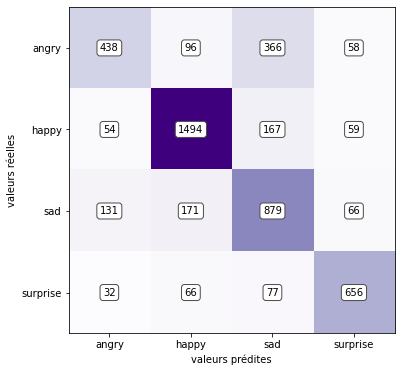

In [52]:
plt.figure(figsize=(6,6))
plt.imshow(cf_matrix, cmap="Purples")
for (i, j), z in np.ndenumerate(cf_matrix):
    plt.text(j, i, z, ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xlabel("valeurs prédites")
plt.xticks(ticks =[i for i in range(4)], labels=[LABELS[i] for i in range(4)])
plt.ylabel("valeurs réelles")
plt.yticks(ticks =[i for i in range(4)], labels=[LABELS[i] for i in range(4)])
plt.show()

### <a id='5'>Résultats</a>

La matrice de confusion nous montre  modèle semble a avoir plus de mal à reconnaître certains sentiments que d'autres. Comme on le voit sur la matrice de confusion que vous avez obtenue ci-dessus.

Si l'on regarde les images de la colère, par exemple : un peu plus de la moitié d'entre elles ont dû être correctement identifiées, mais presque toutes les autres ont probablement été prises pour des expressions de la tristesse. Il y a d'ailleurs aussi beaucoup de mauvaises interprétations du sentiment de tristesse. 

Pas terrible... Qu'en pensez-vous ? 
Maintenant, allez regarder les images du dataset : à l'oeil nu, auriez-vous pu faire mieux ? ;)